In [ ]:
# import general packages
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from numpy.fft import fftn as np_fftn
from functools import reduce
from scipy.interpolate import interp1d
from scipy.optimize import brentq

import h5py
import json
import os
from datetime import datetime

import pde
import phasesep_pyrenoid as ph
from phasesep_pyrenoid.helper_functions import init_from_file, get_waistline_profile_fwhm, dimensionalize_params, get_initial_radius, cmap_exp, cmap_orange, dark_orange, colors, colors_exp, colors_phases, add_scalebar, add_timenote
from phasesep_pyrenoid.solvers_simulations import solve_stokes_flow, run_simulation
from droplets import DiffuseDroplet, Emulsion, SphericalDroplet, image_analysis

radius_micrometer = 1 # [micro meter]
shrinking_time = 10 # [minutes]

with open("./simulation_results/Paper/definite/charact_scales.json", "r") as f:
    charact_scales = json.load(f)
T_char, L_char, P_char = (charact_scales[k] for k in ("T_char", "L_char", "P_char"))

FOLDER_RESULTS = "./simulation_results/Paper/definite/puncta_formation"
FOLDER_FIGURES= "./simulation_results/Paper/figures_for_paper/"

In [155]:
# Plot total fluorescence in pyrenoid and outside over time
gray_shades = ['0.7', '0.1']
horiz_section = []
times = [0, 90]

for i, time in enumerate(times):
    UM_fields = storage_read2[int(time)]
    data = np.transpose(UM_fields.data[0][:,40])
    horiz_section.append(data)
    
xvalues = np.linspace(0,80,80)/scale_length
fig, ax = plt.subplots(figsize=(3.5,2.5))
for i in range(len(horiz_section)):
    plt.plot(xvalues, horiz_section[i], '-', color = gray_shades[i])
plt.hlines(0.1,0,5.6, linestyle = "--", label = r"$c_\infty$")

arrow = patches.FancyArrowPatch((3.5, 1), (5, 1), arrowstyle='<->', 
                        color='black', linewidth=1, mutation_scale=10)
ax.add_patch(arrow)
ax.text(4.2, 0.9, '$\ell$', fontsize=10, color='black')

plt.xlabel(r"x [$\mu m$]")
plt.ylabel(r"$\phi_U$")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

NameError: name 'storage_read2' is not defined

In [ ]:
GRID = pde.CartesianGrid([[0, params["shape"]], [0, params["shape"]]], [params["size"], params["size"]], periodic=params["periodic_bc"])
input_filenameU = "./simulation_results/Paper/definite/waistline_shrink/fission_times/2025-09-22_17-22-34/final_config_U.hdf5" #

    #data = np.transpose(UM_fields.data[0]+UM_fields.data[1])

#fieldU = pde.FieldBase.from_file(input_filenameU)

#struc_fac = image_analysis.get_length_scale(fieldU, method = "structure_factor_maximum")

# Radially Averaged Structure Factor from Simulation Data

This workflow computes the **radially averaged structure factor** \(S(k)\) and extracts the **dominant length scale** from a scalar field $(U(\mathbf{x}))$ at multiple time points.

### 1. Load the Data

We load simulation results from an HDF5 file:

$$
U(\mathbf{x}, t) \quad \text{for selected time points } t \in \{50, 100, 199\}
$$

### 2. n-Dimensional Fourier Transform

The Fourier transform of the scalar field is:

$$
\tilde{U}(\mathbf{k}) = \mathrm{FFT}[U(\mathbf{x})]
$$

where $(\mathbf{k})$ is the wavevector in each dimension.

### 3. Structure Factor

The **structure factor** is the normalized power spectrum:

$$
S(\mathbf{k}) = \frac{|\tilde{U}(\mathbf{k})|^2}{\sum_{\mathbf{x}} |U(\mathbf{x})|^2}
$$

This quantifies the intensity of fluctuations at each wavevector.

### 4. Wavevector Magnitudes

The components of the wavevector are:

$$
k_i = \frac{2 \pi n_i}{L_i}, \quad n_i \in \left[-\frac{N_i}{2}, \frac{N_i}{2}\right)
$$

where \(L_i\) is the size of the grid in dimension \(i\), and \(N_i\) is the number of grid points.

The magnitude of the wavevector is:

$$
|\mathbf{k}| = \sqrt{\sum_{i=1}^{d} k_i^2}
$$

### 5. Radial Averaging

We bin the magnitudes of \(\mathbf{k}\) and compute the radially averaged structure factor:

$$
S(k) = \langle S(\mathbf{k}) \rangle_{|\mathbf{k}| \in \text{bin}}
$$

where the average is over all \(\mathbf{k}\) values within a bin of width \(\Delta k\).

### 6. Dominant Length Scale

The dominant wavevector \(k_\text{peak}\) corresponds to the maximum of \(S(k)\) (ignoring \(k=0\)):

$$
k_\text{peak} = \arg \max_{k>0} S(k)
$$

The associated **dominant length scale** is:

$$
L_\text{dominant} = \frac{2 \pi}{k_\text{peak}}
$$

### 7. Summary of Steps

1. Load scalar field \(U(\mathbf{x}, t)\) at different times.  
2. Compute n-dimensional FFT: \(\tilde{U}(\mathbf{k}) = \mathrm{FFT}[U(\mathbf{x})]\).  
3. Compute normalized structure factor: \(S(\mathbf{k}) = |\tilde{U}(\mathbf{k})|^2 / \sum |U(\mathbf{x})|^2\).  
4. Compute wavevector magnitudes: \(|\mathbf{k}| = \sqrt{\sum k_i^2}\).  
5. Bin \(|\mathbf{k}|\) and radially average \(S(\mathbf{k})\) to get \(S(k)\).  
6. Find \(k_\text{peak}\) and compute \(L_\text{dominant} = 2\pi / k_\text{peak}\).  
7. Plot \(S(k)\) versus \(k\) for visualization.


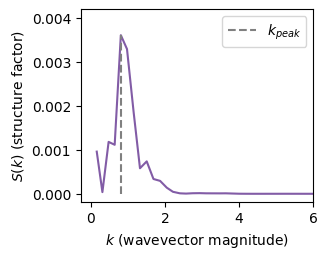

In [ ]:

# Load data
storage_read = pde.FileStorage(FOLDER_RESULTS+"/2025-09-23_14-55-18/final_config.hdf") 
times = [199]
# Plot each time point
plt.figure(figsize=(3,2.5))
for i, time in enumerate(times):
    fieldU = storage_read[time][0]

    scalar_field = fieldU

    grid = scalar_field.grid

    # do the n-dimensional Fourier transform and calculate the structure factor
    f1 = np_fftn(scalar_field.data, norm="ortho").flat[1:]
    flat_data = scalar_field.data.flat
    sf = np.abs(f1) ** 2 / np.dot(flat_data, flat_data)

    # Note that `fftfreq` defines the wave number in cycles per unit of the sample
        # spacing, so we need to scale lengths by one over 2π.
    k2s = [
        np.fft.fftfreq(grid.shape[i], d=grid.discretization[i] / (2 * np.pi)) ** 2
        for i in range(grid.dim)
    ]
    # calculate the magnitude
    k_mag = np.sqrt(reduce(np.add.outer, k2s)).flat[1:]

    # Define bins for k (wavevector magnitudes)
    num_bins = 50  # you can change this
    k_bins = np.linspace(0, np.max(k_mag), num_bins + 1)

    # Digitize: assign each k_mag value to a bin
    bin_indices = np.digitize(k_mag, k_bins)

    # Radially average S(k) over bins
    sf_avg = np.zeros(num_bins)
    k_avg = np.zeros(num_bins)

    for i in range(1, num_bins + 1):
        mask = bin_indices == i
        if np.any(mask):  # avoid empty bins
            sf_avg[i-1] = np.mean(sf[mask])
            k_avg[i-1] = np.mean(k_mag[mask])

    # --- Plot ---

    plt.plot(k_avg, sf_avg, "-", markersize=4, color = "#825CA6")
    plt.xlim(right = 6)
    plt.xlabel(r"$k$ (wavevector magnitude)")
    plt.ylabel(r"$S(k)$ (structure factor)")
    #plt.title("Radially averaged structure factor")
    #plt.show()

    # Find peak (ignore k=0 region just in case)
    valid = k_avg > 0
    k_peak = k_avg[valid][np.argmax(sf_avg[valid])]

    # Convert to dominant length scale
    dominant_length = 2 * np.pi / k_peak
    plt.vlines(k_peak, min(sf_avg), max(sf_avg), linestyle = "--", color = "gray", label = r"$k_{peak}$")
plt.legend()
plt.ylim(top = 0.0042)
plt.savefig(FOLDER_FIGURES+"Power_spectrum.svg", bbox_inches = "tight", transparent = True)

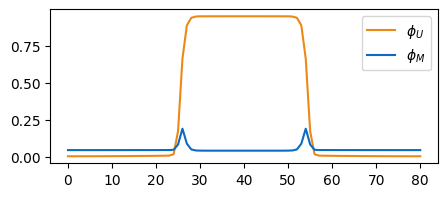

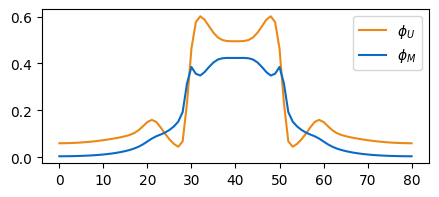

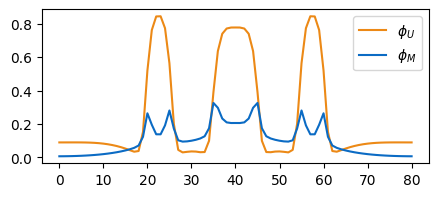

In [132]:
from numpy.fft import fftn as np_fftn
from functools import reduce
# Load data
storage_read = pde.FileStorage(FOLDER_RESULTS+"/2025-09-23_15-17-48/final_config.hdf") 
times = [0,35,100]
# Plot each time point

for i, time in enumerate(times):
    plt.figure(figsize=(5,2))
    fieldU = storage_read[time][0]
    fieldM = storage_read[time][1]
    grid = fieldU.grid

    # --- Plot ---
    plt.plot(fieldU.data[40], "-", markersize=4, color = "#EC8916", label = r"$\phi_U$")
    #plt.xlim(left = 40)
    plt.plot(fieldM.data[40], "-", markersize=4, color = "#0B6BC4", label = r"$\phi_M$")
    plt.legend()
    plt.show()


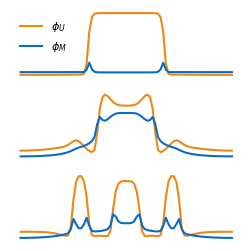

In [153]:
plt.figure(figsize=(3,3))
for i, time in enumerate(times):
    fieldU = storage_read[time][0]
    fieldM = storage_read[time][1]


    plt.subplot(3,1,i+1)
    # --- Plot fields ---
    plt.plot(fieldU.data[40], "-", markersize=4, color="#EC8916", label=r"$\phi_U$")
    plt.plot(fieldM.data[40], "-", markersize=4, color="#0B6BC4", label=r"$\phi_M$")

    # --- Compact formatting ---
    if i == 0:
        plt.legend(frameon=False, fontsize=8, loc = "upper left")      # remove legend box
    plt.xticks([])                             # remove x ticks
    plt.yticks([])                             # remove y ticks
    for spine in plt.gca().spines.values():    # remove all spines
        spine.set_visible(False)
    #plt.tight_layout()                         # reduce margins

plt.savefig(FOLDER_FIGURES+"Reaction_diffusion.svg", bbox_inches = "tight", transparent = True)
plt.show()

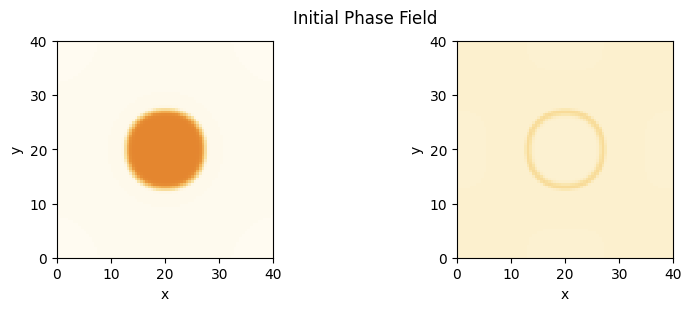

100%|██████████| 200.0/200.0 [02:01<00:00,  1.65it/s]      
100%|██████████| 201/201 [00:11<00:00, 16.84it/s]


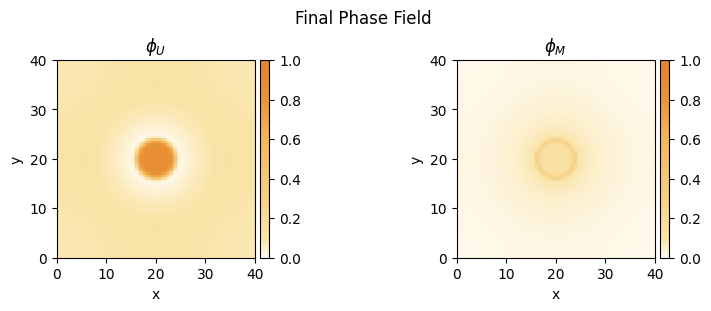

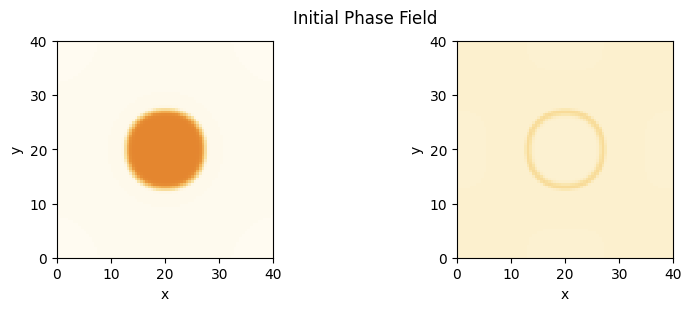

100%|██████████| 200.0/200.0 [01:50<00:00,  1.81it/s]    
100%|██████████| 201/201 [00:12<00:00, 16.38it/s]


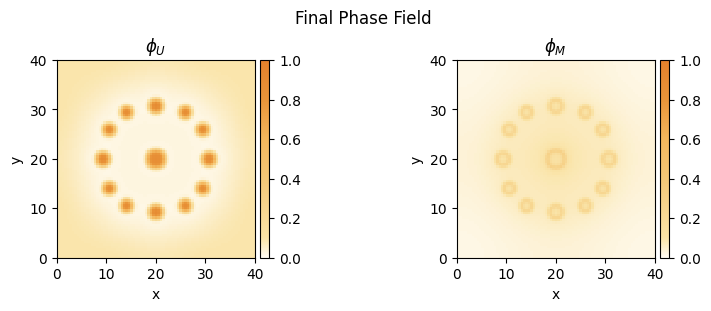

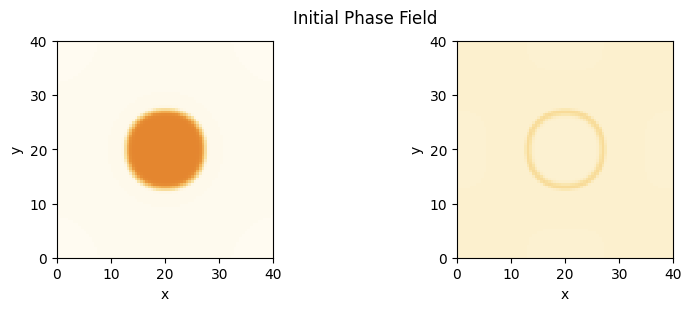

100%|██████████| 200.0/200.0 [01:29<00:00,  2.23it/s]    
100%|██████████| 201/201 [00:11<00:00, 17.77it/s]


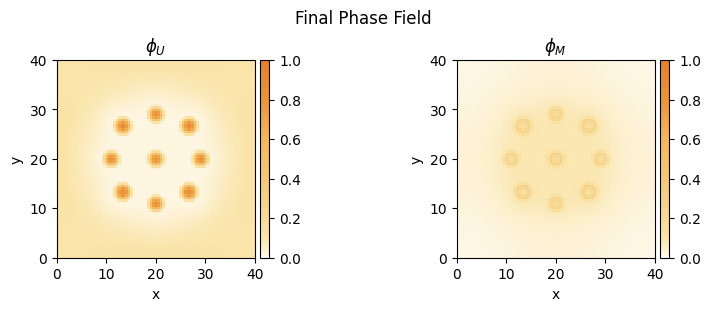

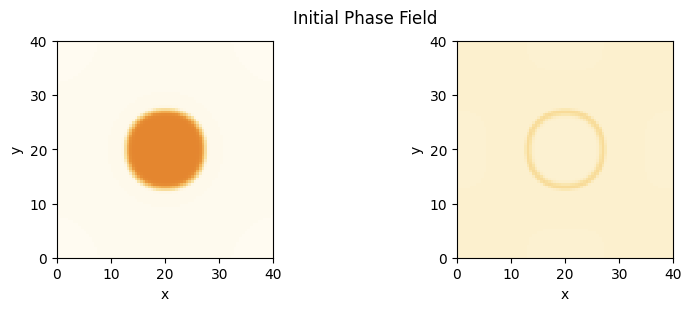

100%|██████████| 200.0/200.0 [01:09<00:00,  2.88it/s]    
100%|██████████| 201/201 [00:11<00:00, 17.42it/s]


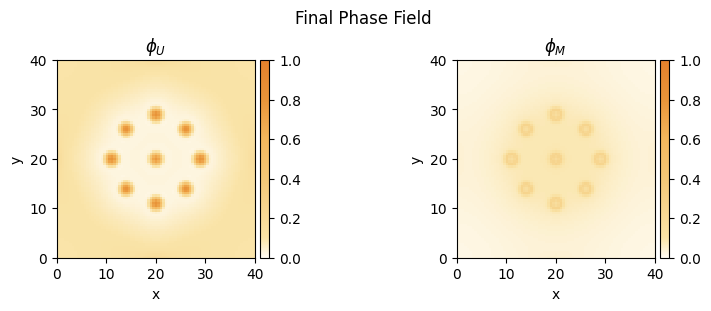

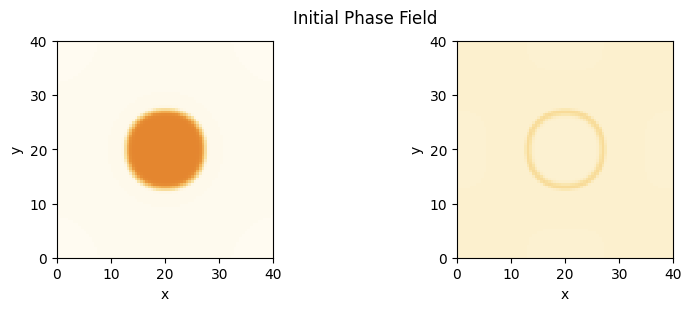

100%|██████████| 200.0/200.0 [00:59<00:00,  3.35it/s]    
100%|██████████| 201/201 [00:11<00:00, 17.82it/s]


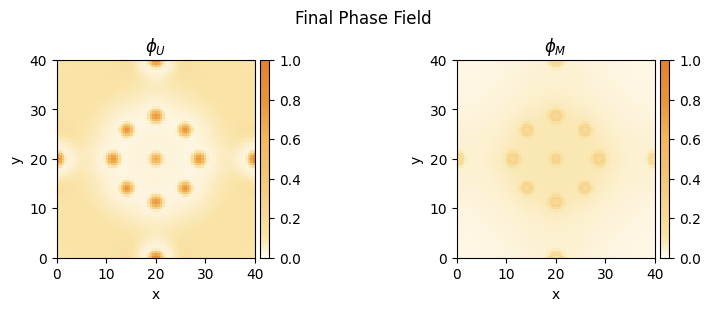

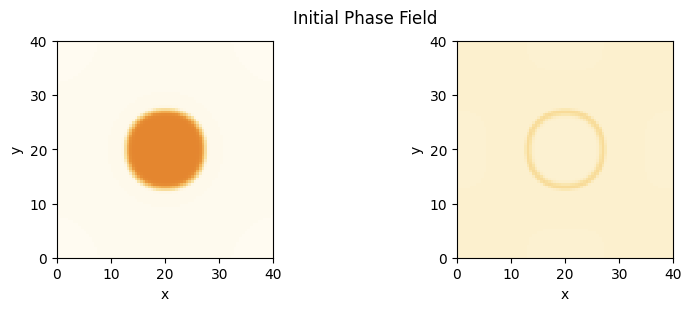

100%|██████████| 200.0/200.0 [02:03<00:00,  1.62it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.46it/s]


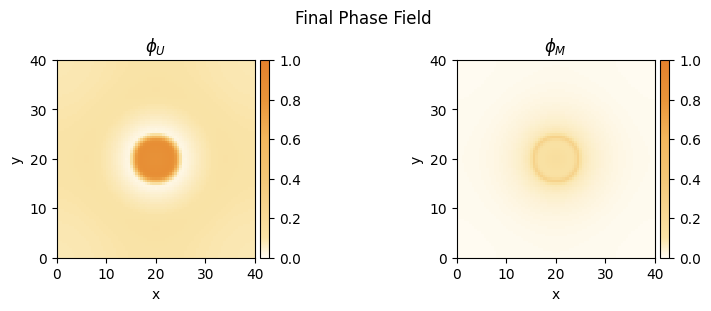

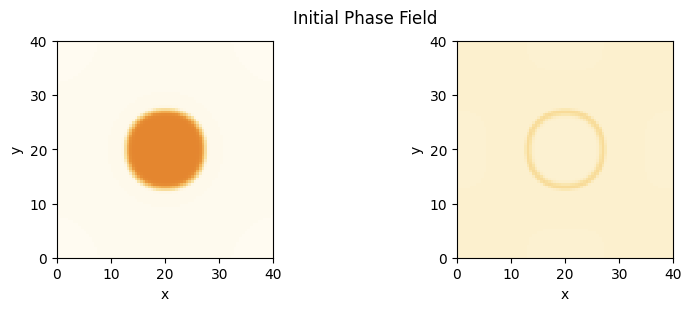

100%|██████████| 200.0/200.0 [01:51<00:00,  1.79it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.54it/s]


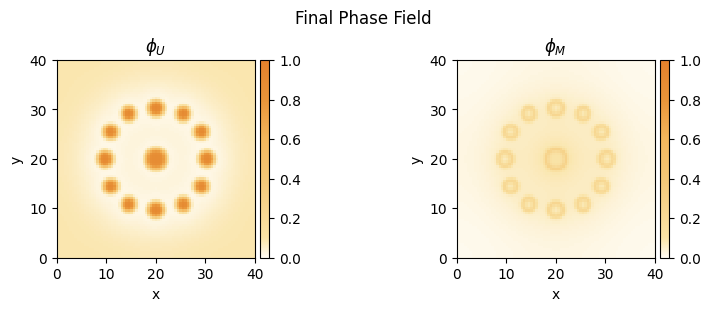

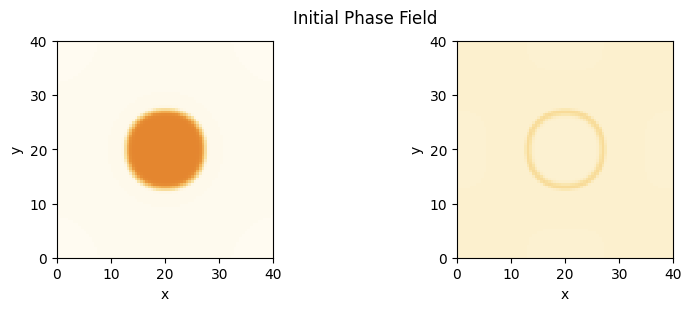

100%|██████████| 200.0/200.0 [01:35<00:00,  2.09it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.46it/s]


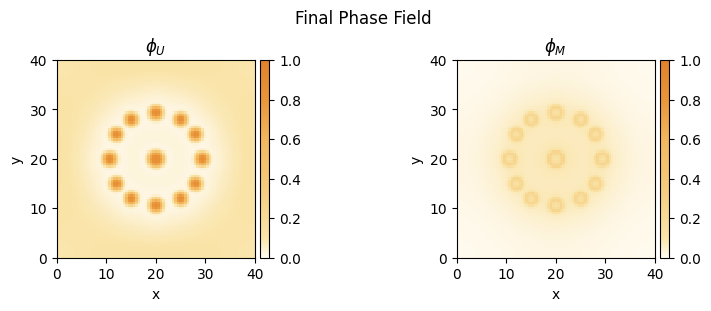

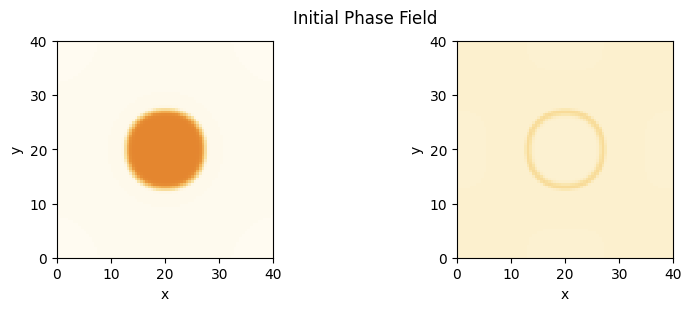

100%|██████████| 200.0/200.0 [01:19<00:00,  2.52it/s]    
100%|██████████| 201/201 [00:11<00:00, 17.79it/s]


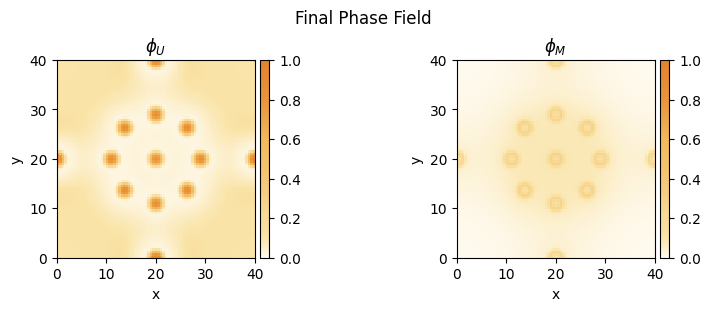

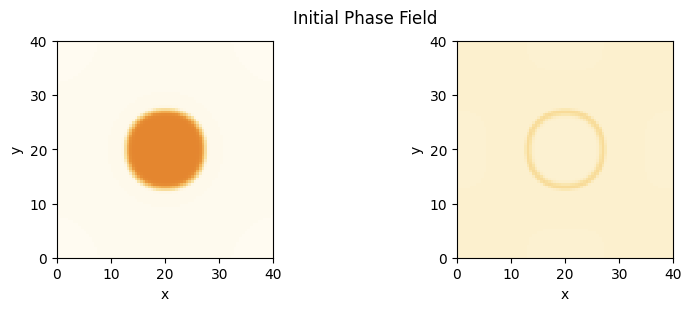

100%|██████████| 200.0/200.0 [01:08<00:00,  2.93it/s]    
100%|██████████| 201/201 [00:11<00:00, 18.18it/s]


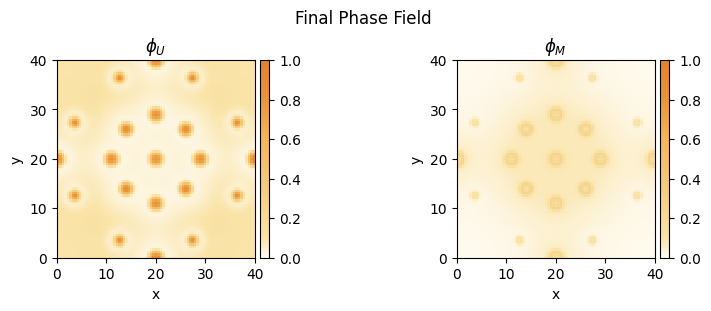

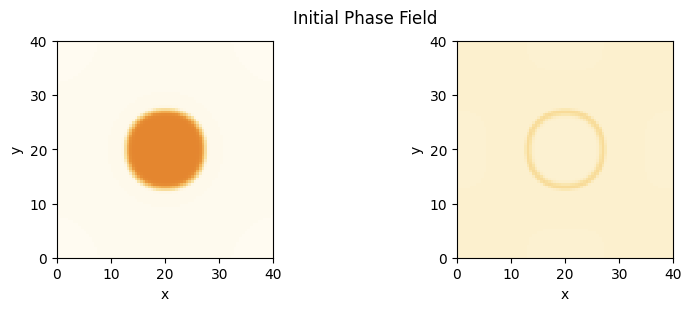

100%|██████████| 200.0/200.0 [02:11<00:00,  1.52it/s]    
100%|██████████| 201/201 [00:14<00:00, 13.50it/s]


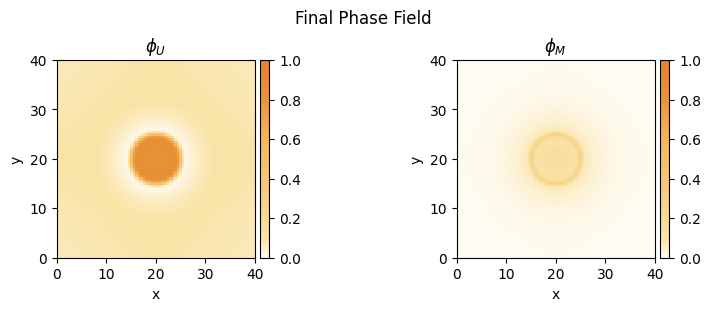

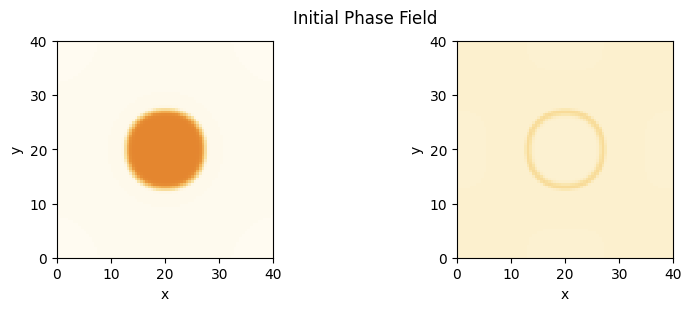

100%|██████████| 200.0/200.0 [01:55<00:00,  1.73it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.68it/s]


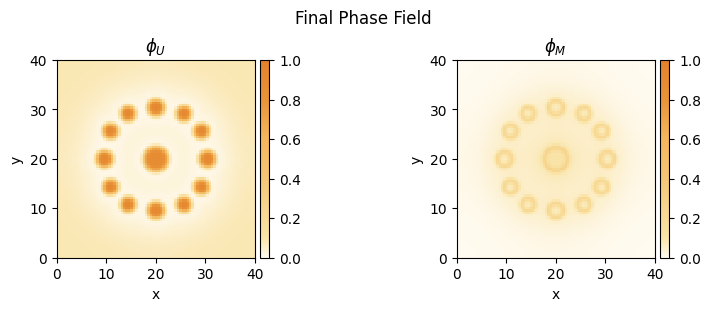

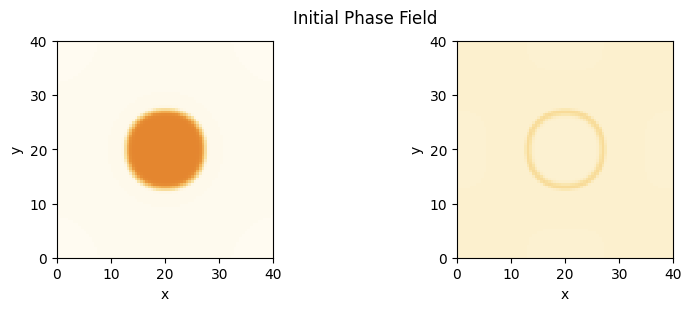

100%|██████████| 200.0/200.0 [01:45<00:00,  1.90it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.79it/s]


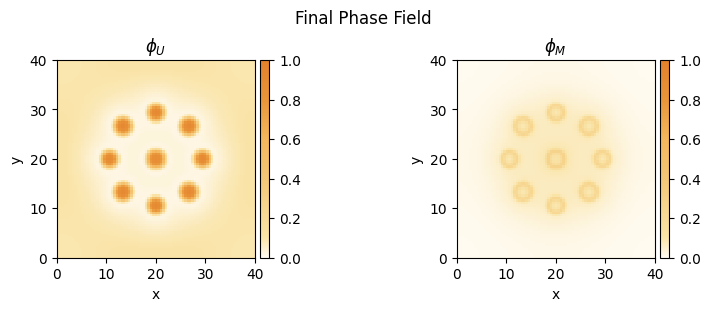

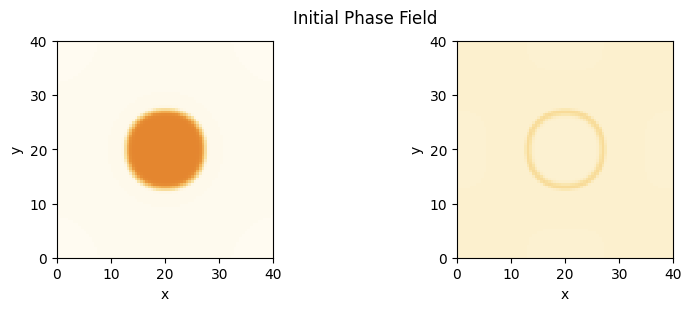

100%|██████████| 200.0/200.0 [01:33<00:00,  2.14it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.76it/s]


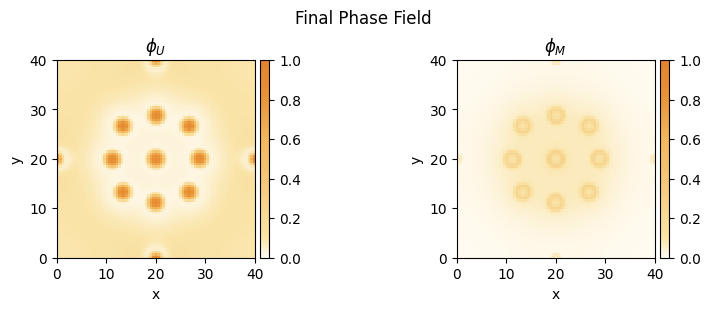

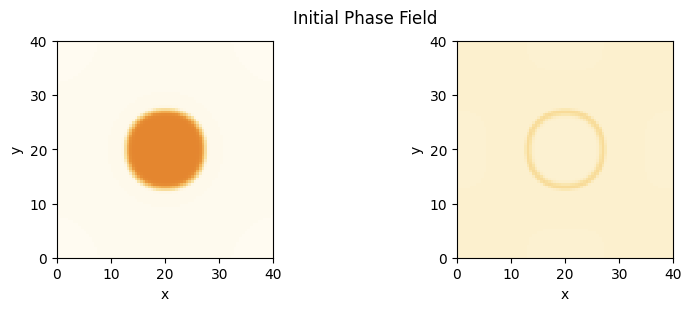

100%|██████████| 200.0/200.0 [01:19<00:00,  2.51it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.65it/s]


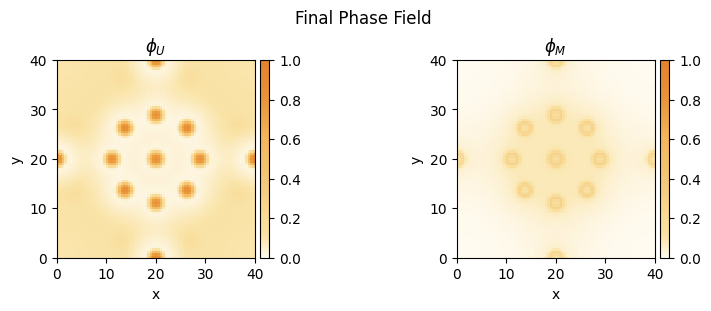

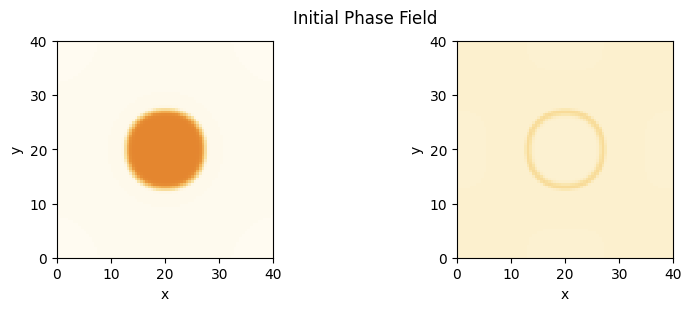

100%|██████████| 200.0/200.0 [02:11<00:00,  1.52it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.39it/s]


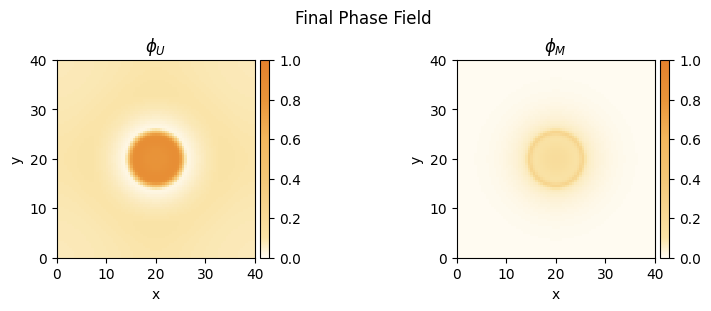

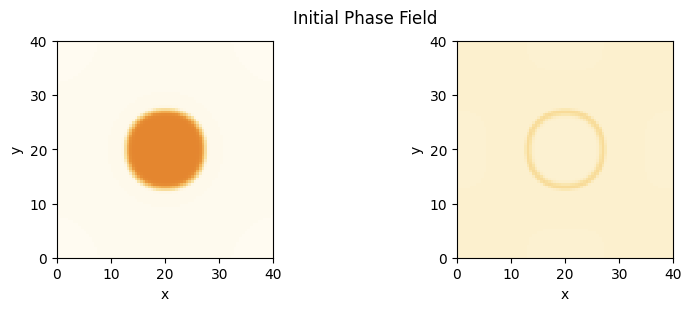

100%|██████████| 200.0/200.0 [02:03<00:00,  1.62it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.41it/s]


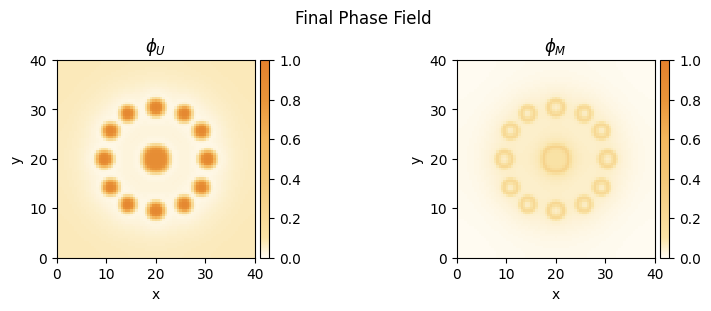

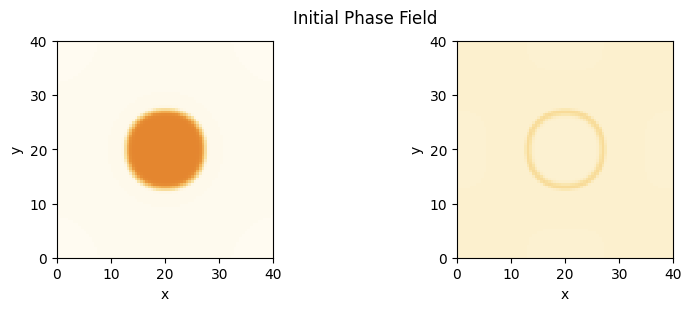

100%|██████████| 200.0/200.0 [01:52<00:00,  1.78it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.87it/s]


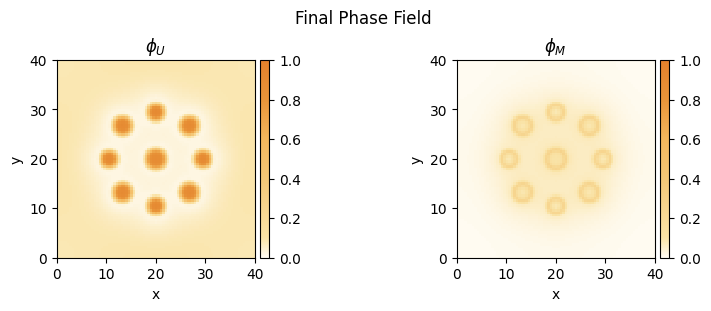

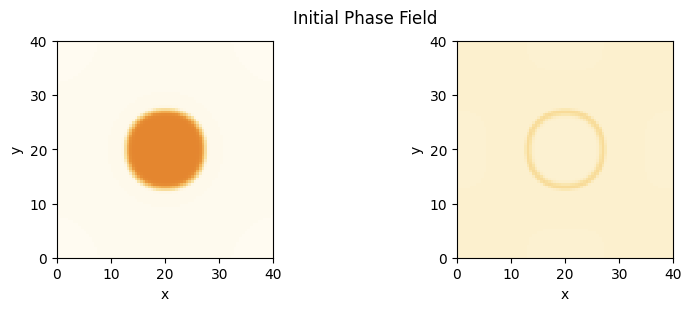

100%|██████████| 200.0/200.0 [01:40<00:00,  1.98it/s]    
100%|██████████| 201/201 [00:11<00:00, 18.13it/s]


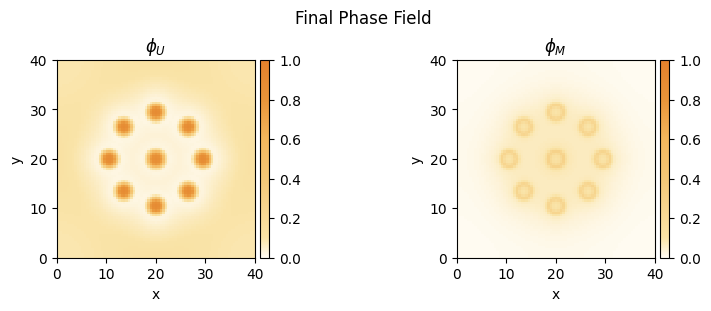

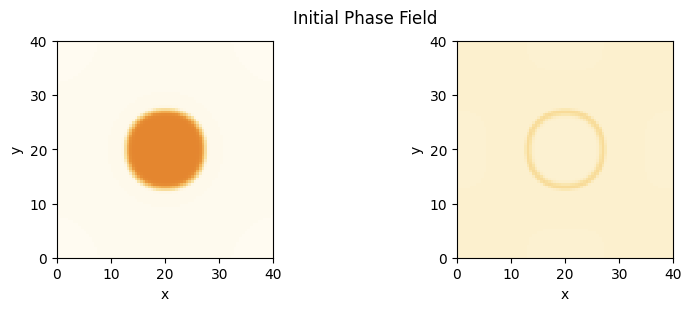

100%|██████████| 200.0/200.0 [01:30<00:00,  2.22it/s]    
100%|██████████| 201/201 [00:11<00:00, 18.16it/s]


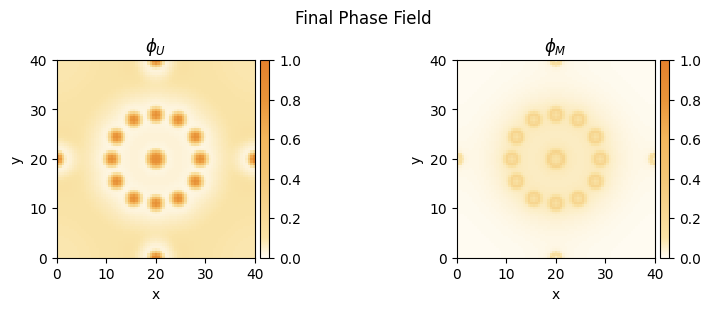

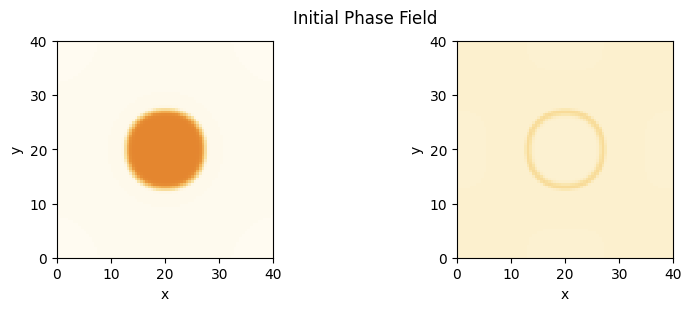

100%|██████████| 200.0/200.0 [02:12<00:00,  1.51it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.44it/s]


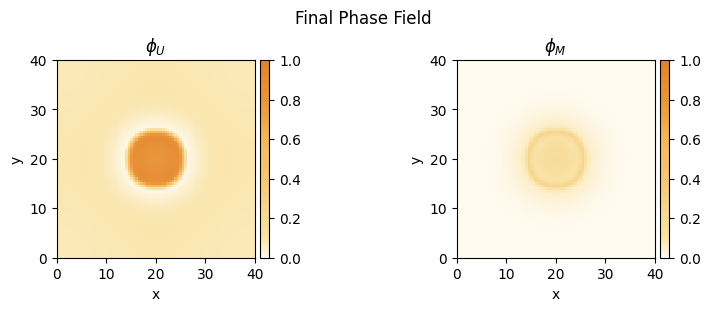

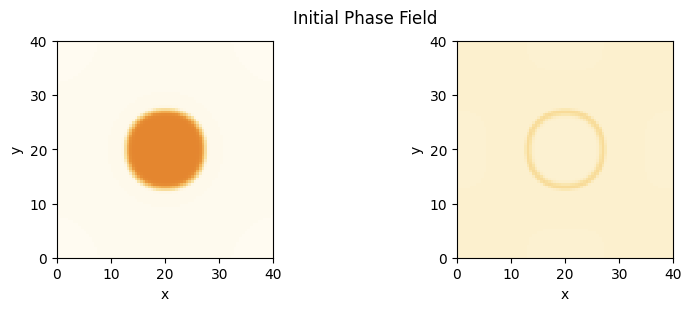

100%|██████████| 200.0/200.0 [02:12<00:00,  1.51it/s]    
100%|██████████| 201/201 [00:11<00:00, 18.16it/s]


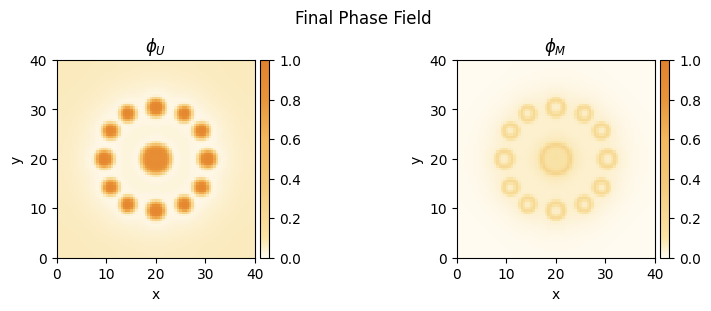

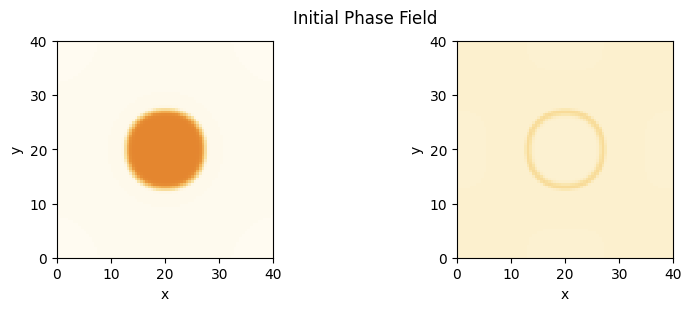

100%|██████████| 200.0/200.0 [01:58<00:00,  1.68it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.50it/s]


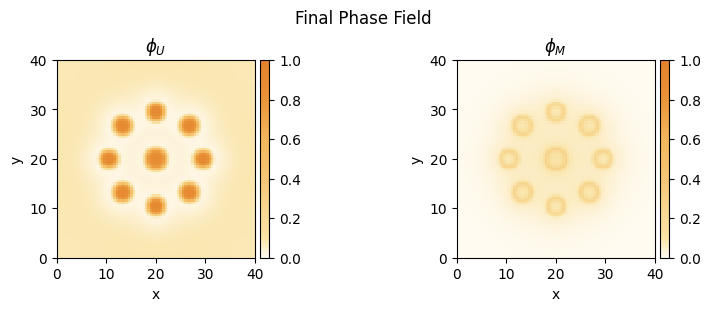

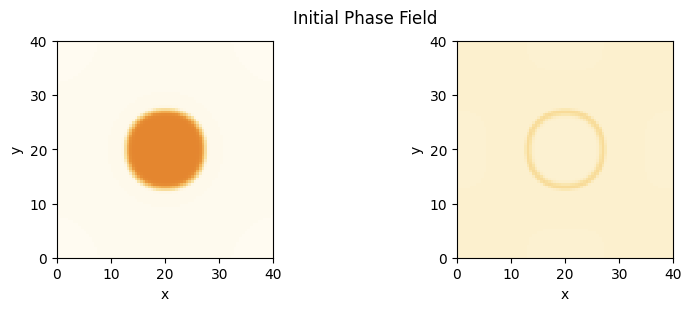

100%|██████████| 200.0/200.0 [01:49<00:00,  1.82it/s]    
100%|██████████| 201/201 [00:11<00:00, 17.65it/s]


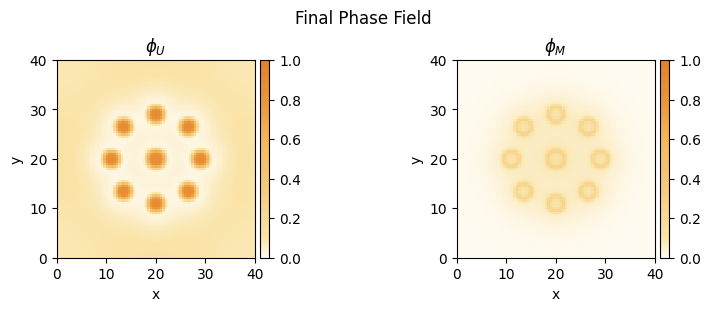

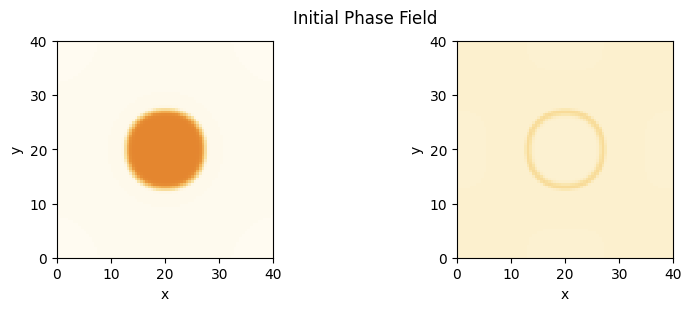

100%|██████████| 200.0/200.0 [01:35<00:00,  2.09it/s]    
100%|██████████| 201/201 [00:11<00:00, 18.04it/s]


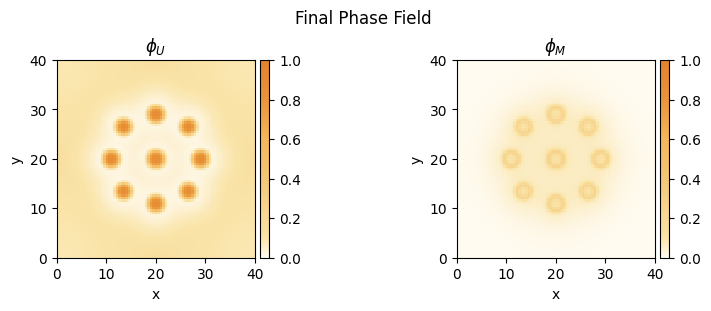

In [3]:
krates = np.linspace(0.02,0.1,5)

for k_rateU in krates:
    for k_rateM in krates:
        chem_react = True
        params_advection = {
                "nx": 83, # Grid size x
                "ny": 83, # Grid size y
                "Lx":40.0, # Domain size x
                "Ly":40.0, # Domain size y
                "mu": 40, # Dynamic viscosity
                "eta": 12.5, # Damping
                "P0": 10, # Max of gaussian pressure
                "sigma_P" : 1.2, # Width of gaussian pressure
            }
        params = {
            "k_M": k_rateM if chem_react else 0,
            "k_U": k_rateU if chem_react else 0,
            "chem_react_type": "ext_maint" if chem_react else "None",
            "xc" : 0.5,
            "b" : 200,
            "d" : 1, #9.6 
            "kappa": 1,
            "chi" : 5, # Positive = repulsion
            "shape" : 40,
            "size" : 81,
            "simulation_time" : 200,
            "periodic_bc" : False,
            "interval_for_tracking" : 1,
            "advection": False
        }

        start_from_input_file = True  #2025-03-07_16-28-16
        input_folder = f"./simulation_results/Paper/definite/2025-09-22_11-32-48/" if start_from_input_file else None
        input_filename = input_folder+"final_config" if start_from_input_file else None #"asym_eq_config_no_chem_react" #f"phase2_asym__chem_react_kM_0.05_kU_0.05_simT_30"#"eq_config_no_chem_react"#f"Upot3_chem_react_kM_0.05_kU_0.05_simT_100"#"eq_config_no_chem_react"#f"Upot_chem_react_kM_0.05_kU_0.05_simT_{simulation_time}"#"eq_config_no_chem_react" #"phase_1_off_chem_react_kM_0.05_kU_0.05_simT_150" #"eq_config_no_chem_react" 

        # Choose initial conditions for U and M
        selected_init_cond_U = "from_file" if start_from_input_file else "single_droplet"  # Change this to "random" or "emulsion" or "single_droplet" or "start_from_input_file"
        selected_init_cond_M = "from_file" if start_from_input_file else "random"  # Can be different from U

        # Define parameters separately for U and M
        PARAMS_INIT_U = {
            "from_file":{ "filename": input_filename,
                "suffix": "_U.hdf5"
            },
            "random": {
                "phi": 0.3,
                "std": 2e-4
            },
            "single_droplet": {
                "phi_out": 0.0001,
                "phi_in": 0.8,
                "radius": 8,
                "position": [22, 20]  # Relative to shape center
            },
            "emulsion": {
                "phi": 0.5,
                "droplets": [
                    {"position": [1/3, 1/3], "radius": 8},
                    {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 3}
                ]
            }
        }

        PARAMS_INIT_M = {
                "from_file":{ "filename": input_filename,
                "suffix": "_M.hdf5",
            },
            "random": {
                "phi": 0.1,
                "std": 2e-4
            },
            "single_droplet": {
                "phi_out": 0.0001,
                "phi_in": 0.8,
                "radius": 8,
                "position": [22, 20]  # Relative to shape center
            },
            "emulsion": {
                "phi_out": 0.0001,
                "phi_in": 0.8,
                "droplets": [
                    {"position": [1/3, 1/3], "radius": 7.5},
                    {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 2.5}
                ]
            }
        }

        save_final_config = True
        ### Save params ###
        if save_final_config:
            run_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
            output_folder = f"{FOLDER_RESULTS}/{run_name}/"
            os.makedirs(output_folder, exist_ok=True)

            with open(f"{output_folder}/params.json", "w") as f:
                json.dump(params, f, indent=4)
            if params["advection"]:
                with open(f"{output_folder}/params_advection.json", "w") as f:
                    json.dump(params_advection, f, indent=4)
        output_filename = output_folder+f"final_config"


        P, u, x, y, X, Y = solve_stokes_flow(**params_advection)

        sol, solver_info = run_simulation(selected_init_cond_U,
            selected_init_cond_M,
            PARAMS_INIT_U[selected_init_cond_U],
            PARAMS_INIT_M[selected_init_cond_M],
            save_final_config, input_filename, output_filename, output_folder, chem_react, u = u, cmapcolor = cmap_orange, **params)


/var/folders/2l/dq7pxpgx0nz8tkgcfl___njw0000gn/T/ipykernel_78254/1021349296.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Purples", len(kM_unique))


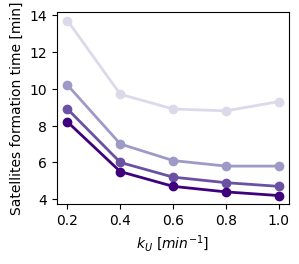

In [164]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
import pde   # PDE library

parent_dir = FOLDER_RESULTS + "/"

# store results
formation_times = {}
kU_values = []
kM_values = []

# threshold for droplet identification
THRESH = 0.5   # <-- adjust to your field scaling

for name in os.listdir(parent_dir):
    full_path = os.path.join(parent_dir, name)
    if os.path.isdir(full_path):
        storage_read = pde.FileStorage(full_path + "/final_config.hdf")

        with open(full_path + '/params.json') as f:
            params = json.load(f)
            kM = params["k_M"]
            kU = params["k_U"]

        # Read all available times
        times = sorted(storage_read.times)
        t_form = np.nan  # if no satellites form

        for time in times:
            fieldU = storage_read[int(time)][0]
            scalar_field = fieldU.data

            # simple thresholding for droplets
            mask = scalar_field > THRESH

            # connected components
            structure = np.ones((3,) * scalar_field.ndim)  # connectivity
            labeled, num = label(mask, structure=structure)

            if num > 1:
                t_form = time
                break  # first time satellites form → stop scanning

        formation_times[(kU, kM)] = t_form
        kU_values.append(kU)
        kM_values.append(kM)

# ---- Plot t_form vs kU for each kM ----
kU_unique = sorted(set(kU_values))
kM_unique = sorted(set(kM_values))

import matplotlib.cm as cm
import matplotlib.colors as mcolors
plt.figure(figsize=(3,2.5))
# use colormap from light to dark purple
cmap = cm.get_cmap("Purples", len(kM_unique))
norm = mcolors.Normalize(vmin=0, vmax=len(kM_unique)-1)

for idx, km in enumerate(sorted(kM_unique)):
    times_list = []
    for ku in kU_unique:
        times_list.append(formation_times.get((ku, km), np.nan))
    plt.plot(np.array(kU_unique)/T_char, np.array(times_list)*T_char, color=cmap(norm(idx)), linewidth=2, marker = "o")#, label=f"$k_M={km}$")

plt.xlabel(r"$k_U\ [min^{-1}]$")
plt.ylabel("Satellites formation time [min]")
#plt.legend(title="$k_M$")
plt.savefig(FOLDER_FIGURES+"satellite_times.svg", bbox_inches = "tight")
